In [3]:
from utils.F4 import BacktestInformation
import pandas as pd
import datetime
from ta.volume import MFIIndicator

In [9]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [4]:
# Low-pass filter dùng cho lọc nhiễu data
from scipy.signal import butter, lfilter
def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [6]:
#path to expiration_date file
df = pd.read_csv('data/expiration_date.csv')
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))

In [14]:
data = pd.read_csv('data/data1mins.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
# AverageTrueRange, CCIIndicator, IchimokuIndicator, MACD, RSI, ADXIndicator, MFI, stochastic,
def alpha(data, params):
    data['Close_filtered'] = pd.Series(lowpass_filter(data['Close'], params['t1']))#0.75. dùng lowpass_filter để lọc bớt nhiễu
    #tính chỉ báo 
    data['MFI'] = MFIIndicator(high = data['High'], low = data['Low'], close = data['Close_filtered'], volume = data['Volume'], window=params['w1']).money_flow_index()#.w1: của sổ của chỉ báo
    #
    data['MFI2'] = MFIIndicator(high = data['High'], low = data['Low'], close = data['Close_filtered'], volume = data['Volume'], window=15).money_flow_index()
    data['MFI3'] = MFIIndicator(high = data['High'], low = data['Low'], close = data['Close_filtered'], volume = data['Volume'], window=params['w1']).money_flow_index()
    data['MFI4'] = MFIIndicator(high = data['High'], low = data['Low'], close = data['Close_filtered'], volume = data['Volume'], window=params['w1']).money_flow_index()
    pos = 0
    position = []
    for i in range(len(data)):
        #
        MFI = data['MFI'].values[i]
        #
        if pos == 0:
            #điều kiện enter short
            if MFI < params['t2']:#13. threshold to enter short 30
                pos = -1
            #điều kiện vào long
            if MFI > params['t3']:#81. threshold to enter long 70
                pos = 1
        elif pos == -1:
            #thoát short
            if MFI > params['t4']:#59. threshold to exit short
                pos = 0
        else:
            #thoát long
            if MFI < params['t5']:#37. threshold to exit long
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            #thoát short cuối ngày(CÓ THỂ HOẶC KHÔNG)
            if pos == - 1:
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                #reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)
    #mục đích cuối cùng vẫn là cột pos(position)
    data['pos'] = position
    return data
#CÁC ĐIỀU KIỆN CÓ TRÊN LÀ NHỮNG ĐIỀU KIỆN ĐƠN SƠ, ĐỂ CÓ 1 ALPHA TỐT, RESEARCHER CẦN NGHIÊN CỨU VÀ ADD THÊM CÁC ĐIỀU KIỆN KHÁC

In [15]:
params = {'t1': 0.75, 't2': 13, 't3': 81, 't4': 59, 't5': 37, 'w1': 14}
ds = alpha(data, params)

In [16]:
ds

Unnamed: 0                Date    Open   Close    High     Low  \
0                0 2017-08-10 09:16:00   757.9   757.9   757.9   757.9   
1                1 2017-08-10 09:19:00   757.0   757.0   757.0   757.0   
2                2 2017-08-10 09:22:00   756.8   756.8   756.8   756.8   
3                3 2017-08-10 09:25:00   756.2   756.2   756.2   756.2   
4                4 2017-08-10 09:28:00   755.5   755.5   755.5   755.5   
...            ...                 ...     ...     ...     ...     ...   
437779      437779 2024-11-05 14:27:00  1320.5  1320.0  1320.8  1320.0   
437780      437780 2024-11-05 14:28:00  1320.1  1320.0  1320.1  1319.6   
437781      437781 2024-11-05 14:29:00  1319.9  1320.2  1320.3  1319.9   
437782      437782 2024-11-05 14:30:00  1320.2  1320.3  1320.3  1320.2   
437783      437783 2024-11-05 14:45:00  1319.0  1319.0  1319.0  1319.0   

        Volume  Close_filtered        MFI       MFI2       MFI3       MFI4  \
0          6.0      535.916229        NaN        NaN        NaN        NaN   
1          4.0      849.212292        NaN        NaN        NaN        NaN   
2          5.0      718.662997        NaN        NaN        NaN        NaN   
3          6.0      772.172600        NaN        NaN        NaN        NaN   
4          5.0      749.088958        NaN        NaN        NaN        NaN   
...        ...             ...        ...        ...        ...        ...   
437779  1386.0     1320.160121  62.905792  55.806943  62.669680  51.780081   
437780   521.0     1319.933676  86.932296  61.024415  59.173625  54.195716   
437781  1008.0     1320.168894  83.233856  61.236410  60.168760  54.210268   
437782    53.0     1320.283595  81.892530  60.277206  56.494146  52.816550   
437783  5517.0     1319.387556  38.843944  43.120825  39.609491  45.740213   

        pos  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
437779    0  
437780    1  
437781    1  
437782    1  
437783    1  

[437784 rows x 13 columns]

Margin: 0.25
MDD: 444.1 (28.23%)

   Total trading quantity: 14446
         Profit per trade: -2.64
             Total Profit: 791.7
         Profit after fee: -38131.1
 Trading quantity per day: 7.98
 Profit per day after fee: -21.07
                   Return: -3.34
          Profit per year: -5261.95
                  HitRate: 0.36
          HitRate per day: 0.5


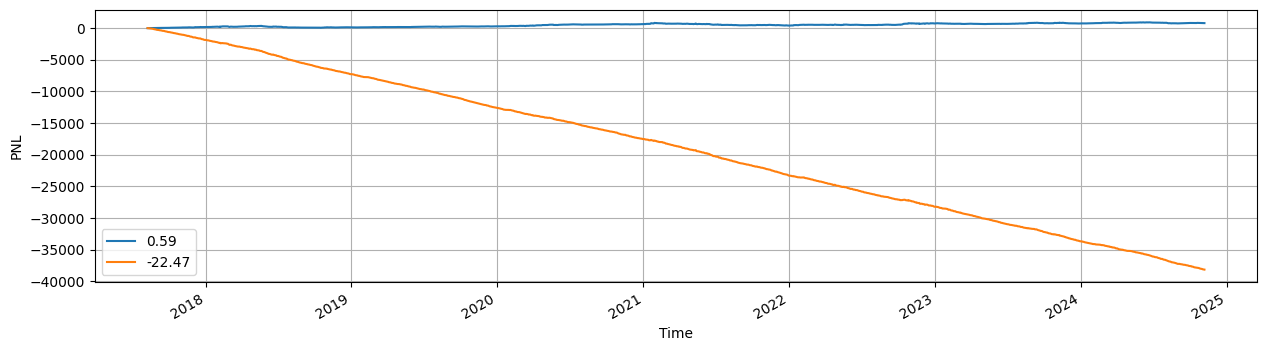

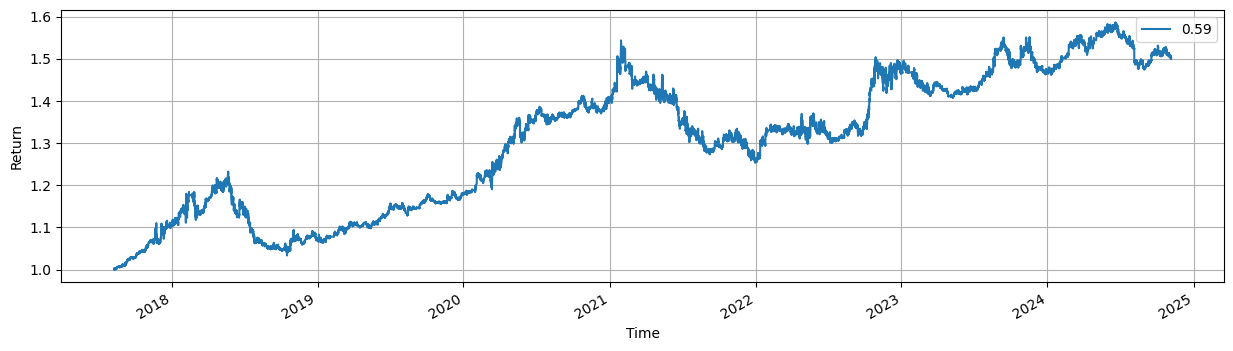

In [22]:
# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

params = {'t1': 0.75, 't2': 30, 't3': 70, 't4': 59, 't5': 37, 'w1': 14} ##CÁC THAM SỐ NÀY CẦN ĐƯỢC ĐIỀU CHỈNH ĐỂ TỐI ƯU LỢI NHUẬN CHO CHIẾN LƯỢC
ds = alpha(data, params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()